In [78]:
import os
import pathlib
import json
import pandas as pd
import matplotlib.pyplot as plt
import collections

from sklearn.model_selection import train_test_split

In [79]:
DATA_RAW   = "data/raw/emoattcap"
DATA_IMG   = "data/images"
SPLIT_DIR  = pathlib.Path("data/splits")
SPLIT_DIR.mkdir(exist_ok=True)

pathlib.Path(SPLIT_DIR).mkdir(parents=True, exist_ok=True)

In [80]:
# Load CSV and rename columns for consistency
csv_path = pathlib.Path(DATA_RAW) / "emo-at-cap.csv"
dataframe = pd.read_csv(csv_path).rename(columns={
    "image_name":      "img_name",
    "annotation":      "caption",
    "human_sentiment": "emotion"
})
print("Columns present:", dataframe.columns.tolist())


Columns present: ['img_name', 'caption', 'emotion', 'sentiment']


In [81]:
# Build full image paths and apply basic filters

# prepend the DATA_IMG path to each filename
dataframe["img_name"] = dataframe["img_name"].apply(lambda n: pathlib.Path(DATA_IMG) / n)
print("Initial total:", len(dataframe))

# filter out empty captions
dataframe = dataframe[dataframe["caption"].str.strip().ne("")]
print("After caption:", len(dataframe))

# filter out records whose image file doesn’t exist
dataframe = dataframe[dataframe["img_name"].apply(lambda p: p.exists())].reset_index(drop=True)
print("After image check:", len(dataframe))

Initial total: 3840
After caption: 3840
After image check: 3840


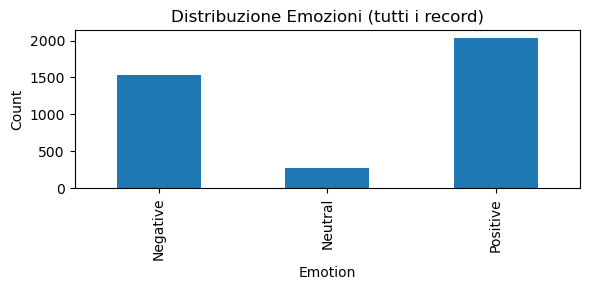

In [82]:
# Plot emotion distribution
dataframe["emotion"].value_counts().sort_index().plot(kind="bar", figsize=(6,3))
plt.title("Distribuzione Emozioni (tutti i record)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [83]:
# Stratified 80/10/10 split
train_df, temp_df = train_test_split(dataframe, test_size=0.20,
                                     stratify=dataframe["emotion"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50,
                                   stratify=temp_df["emotion"], random_state=42)

# Save each split as JSON
for name, split_df in [("train", train_df),
                       ("val",   val_df),
                       ("test",  test_df)]:
    out_df = split_df.copy()
    # converte i Path in stringhe
    out_df["img_name"] = out_df["img_name"].astype(str)

    records = out_df[["img_name","caption","emotion"]] \
        .to_dict(orient="records")

    out_path = SPLIT_DIR / f"{name}.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(records, f, ensure_ascii=False, indent=2)
    print(f"{name.upper():5s}: {len(records):4d} esempi salvati in {out_path}")

TRAIN: 3072 esempi salvati in data\splits\train.json
VAL  :  384 esempi salvati in data\splits\val.json
TEST :  384 esempi salvati in data\splits\test.json


In [86]:
# Verify splits by counting emotions
def count_emotions(json_file):
    with open(json_file, encoding="utf-8") as f:
        data = json.load(f)
    return collections.Counter(r["emotion"] for r in data)

for split in ["train","val","test"]:
    cnt = count_emotions(pathlib.Path(SPLIT_DIR) / f"{split}.json")
    print(f"{split.capitalize():<5} ⇒", dict(cnt))

print("\nImages directory:", len(os.listdir(DATA_IMG)), "file JPG")


Train ⇒ {'Negative': 1224, 'Positive': 1630, 'Neutral': 218}
Val   ⇒ {'Positive': 204, 'Negative': 153, 'Neutral': 27}
Test  ⇒ {'Negative': 153, 'Positive': 203, 'Neutral': 28}

Images directory: 3840 file JPG
